# Basic modelling of Music Recommendation System

**Submitted By:** Debojyoti Choudhury

**Enrollment Number:** 40AIML137-21/2

**Programme:** Diploma in AI and ML

The purpose of this notebook is to take the preprocessed (model-ready) data and build basic models using it.

## Importing necessary libraries

In [1]:
import numpy as np                                                    # for fast processing of tabular data
import pandas as pd                                                   # data processing, CSV file I/O
import matplotlib.pyplot as plt                                       # for data visualization
import seaborn as sns                                                 # for data visualization
from sklearn.linear_model import LogisticRegression                   # for logistic regression
from sklearn.model_selection import RandomizedSearchCV                # for randomised-search based hyper parameter tuning
from sklearn.tree import DecisionTreeClassifier                       # for decision tree classifier
from sklearn.linear_model import SGDClassifier                        # for support vector machine classifier
from sklearn.metrics import roc_auc_score, accuracy_score             # metrics to identify classifier performance
from sklearn.metrics import classification_report                     # to produce classsifier report
from sklearn.metrics import roc_curve, plot_roc_curve, auc            # for plotting roc curve
from sklearn.metrics import plot_confusion_matrix                     # for plotting confusion matrix
import time                                                           # to keep track of time the algorithm takes

## Read the sample dataset

As the system configuration is not enough to handle all the data we will use sampled dataset to train our models.

In [2]:
train_data = pd.read_csv("../Data/sampled_data/sampled_train_data.csv.gz", compression='gzip',index_col=False)
validation_data = pd.read_csv("../Data/sampled_data/sampled_validation_data.csv.gz", compression='gzip', index_col=False)

In [3]:
train_data.shape, validation_data.shape

((1180387, 43), (295097, 43))

## Selecting X_tr, y_tr, X_val, y_val

In [4]:
features = train_data.drop(['Unnamed: 0','song_id', 'target'], axis=1).columns
features

Index(['msno', 'source_system_tab', 'source_screen_name', 'source_type',
       'city', 'bd', 'gender', 'registered_via', 'registration_year',
       'registration_month', 'registration_day', 'expiration_year',
       'expiration_month', 'expiration_day', 'membership_days', 'song_length',
       'first_genre_id', 'second_genre_id', 'third_genre_id',
       'genre_ids_count', 'artist_name', 'language', 'is_featured',
       'artist_count', 'first_artist_name', 'lyricist_count', 'first_lyricist',
       'composer_count', 'first_composer', 'country_code', 'registration_code',
       'song_year', 'member_song_count', 'artist_song_count',
       'composer_song_count', 'lyricist_song_count', 'genre_song_count',
       'lang_song_count', 'song_member_count', 'age_song_count'],
      dtype='object')

In [5]:
X_tr = train_data.drop(['Unnamed: 0', 'song_id', 'target'], axis=1)
y_tr = train_data['target']

X_val = validation_data.drop(['Unnamed: 0','song_id', 'target'], axis=1)
y_val = validation_data['target']

In [6]:
X_tr.shape, y_tr.shape, X_val.shape, y_val.shape

((1180387, 40), (1180387,), (295097, 40), (295097,))

## Logistic Regression

### Fitting Logistic Regression Model

In [7]:
clf = LogisticRegression(max_iter=10000, C=1)

In [8]:
clf.fit(X_tr, y_tr)

LogisticRegression(C=1, max_iter=10000)

### Generating the classification reports

In [9]:
def class_report(estimator):
    estimator_name = estimator.__class__.__name__
    print("Classification Report of ", estimator_name," on training dataset\n")
    y_p = estimator.predict(X_tr)
    print(classification_report(y_true = y_tr, y_pred = y_p))
    print("\n")
    print("Classification Report of ", estimator_name," on validation dataset\n")
    y_p = estimator.predict(X_val)
    print(classification_report(y_true = y_val, y_pred = y_p))

In [10]:
class_report(clf)

Classification Report of  LogisticRegression  on training dataset

              precision    recall  f1-score   support

           0       0.60      0.53      0.57    586166
           1       0.59      0.65      0.62    594221

    accuracy                           0.59   1180387
   macro avg       0.59      0.59      0.59   1180387
weighted avg       0.59      0.59      0.59   1180387



Classification Report of  LogisticRegression  on validation dataset

              precision    recall  f1-score   support

           0       0.60      0.54      0.57    146548
           1       0.59      0.65      0.62    148549

    accuracy                           0.60    295097
   macro avg       0.60      0.59      0.59    295097
weighted avg       0.60      0.60      0.59    295097



### ROC-AUC

In [11]:
def plot_roc(estimator):
    estimator_name = estimator.__class__.__name__
    
    y_p = estimator.predict_proba(X_tr)[:,1]
    fprt, tprt, _ = roc_curve(y_true=y_tr, y_score=y_p)
    roc_auc_tr = auc(fprt, tprt)
    
    y_p = estimator.predict_proba(X_val)[:,1]
    fprv, tprv, _ = roc_curve(y_true=y_val, y_score=y_p)
    roc_auc_val = auc(fprv, tprv)
    
    plt.figure(figsize=(10,8))
    lw = 1.5
    plt.plot(
        fprt,
        tprt,
        color="green",
        lw=lw,
        label="ROC curve (area = %0.2f) on training dataset" % roc_auc_tr,
    )
    plt.plot(
        fprv,
        tprv,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f) on validation dataset" % roc_auc_val,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title(f"Receiver operating characteristic of {estimator_name} model", fontsize=14)
    plt.legend(loc="lower right")
    plt.show()

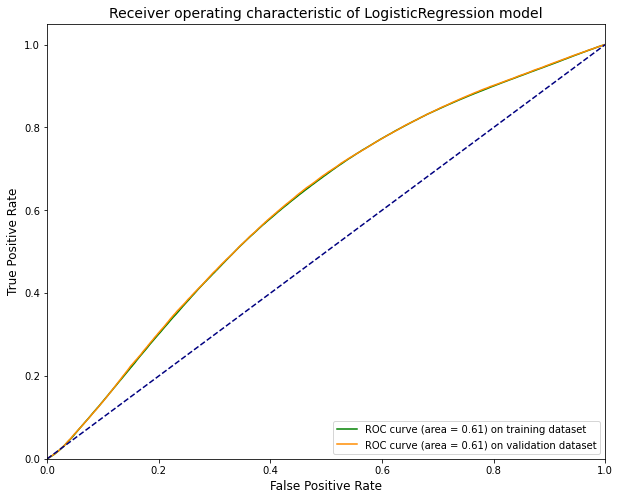

In [12]:
plot_roc(clf)

We can see almost similar nature of train and validation RoC curve

### Error analysis : Confusion Matrix on validation dataset

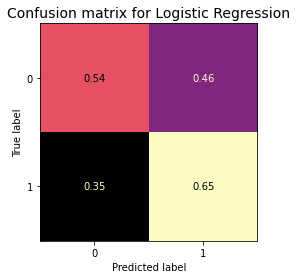

In [13]:
plot_confusion_matrix(clf, X_val, y_val, normalize = 'true', colorbar=False, cmap='magma')
plt.title("Confusion matrix for Logistic Regression", fontsize=14)
plt.show()

### Feature importance

In [14]:
def plot_feature_importance(data, model):
    '''Function to plot top-20 feature imporatance'''
    plt.figure(figsize=(15,10))
    sns.set(font_scale=1.25)
    sns.set(style="whitegrid")
    plt.xlabel('features',fontsize=14)
    plt.ylabel('importance',fontsize=14)
    plt.xticks(rotation='90')
    ax = sns.barplot(x='features', y='importance', data=data)
    plt.title('Top 20 features ranked by importance for {model}'.format(model=model),fontsize=16)
    plt.tight_layout()

In [15]:
# create dataframe for features and it importance

sorted_indices = np.abs(clf.coef_[0]).argsort()[::-1][:20]
imp_features = features[sorted_indices]
lr_fea_imp = pd.DataFrame({
    'features' : imp_features,
    'importance' : np.abs(clf.coef_[0])[sorted_indices]
})

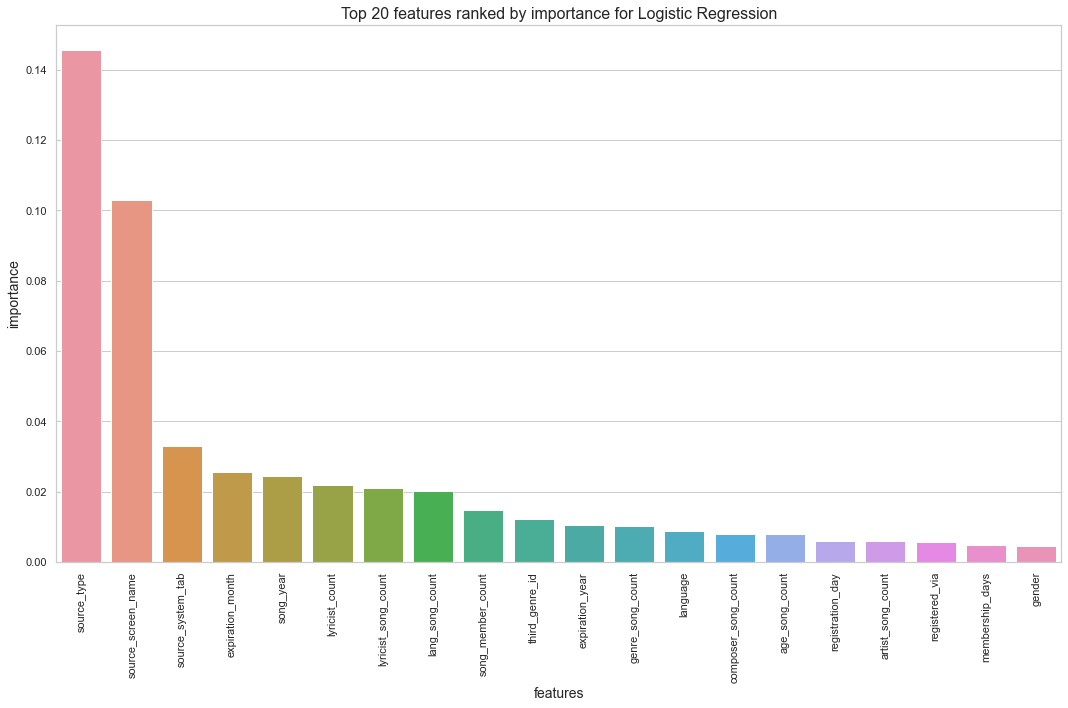

In [16]:
plot_feature_importance(data=lr_fea_imp, model='Logistic Regression')

## Support Vector Classifier

### Fiiting Support Vector Classifier

In [17]:
svc_clf = SGDClassifier(loss='hinge', max_iter=10000)

In [18]:
svc_clf.fit(X_tr, y_tr)

SGDClassifier(max_iter=10000)

### Generating the classification report

In [19]:
class_report(svc_clf)

Classification Report of  SGDClassifier  on training dataset

              precision    recall  f1-score   support

           0       0.57      0.04      0.07    586166
           1       0.51      0.97      0.67    594221

    accuracy                           0.51   1180387
   macro avg       0.54      0.50      0.37   1180387
weighted avg       0.54      0.51      0.37   1180387



Classification Report of  SGDClassifier  on validation dataset

              precision    recall  f1-score   support

           0       0.56      0.04      0.07    146548
           1       0.51      0.97      0.67    148549

    accuracy                           0.51    295097
   macro avg       0.53      0.50      0.37    295097
weighted avg       0.53      0.51      0.37    295097



### Error Analysis : Confusion Matrix on validation dataset

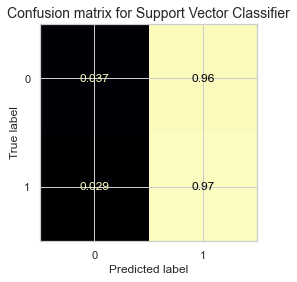

In [20]:
plot_confusion_matrix(svc_clf, X_val, y_val, normalize = 'true', colorbar=False, cmap='magma')
plt.title("Confusion matrix for Support Vector Classifier", fontsize=14)
plt.show()

### Feature importance

In [21]:
# create dataframe for features and it importance

sorted_indices = np.abs(svc_clf.coef_[0]).argsort()[::-1][:20]
imp_features = features[sorted_indices]
svc_fea_imp = pd.DataFrame({
    'features' : imp_features,
    'importance' : np.abs(svc_clf.coef_[0])[sorted_indices]
})

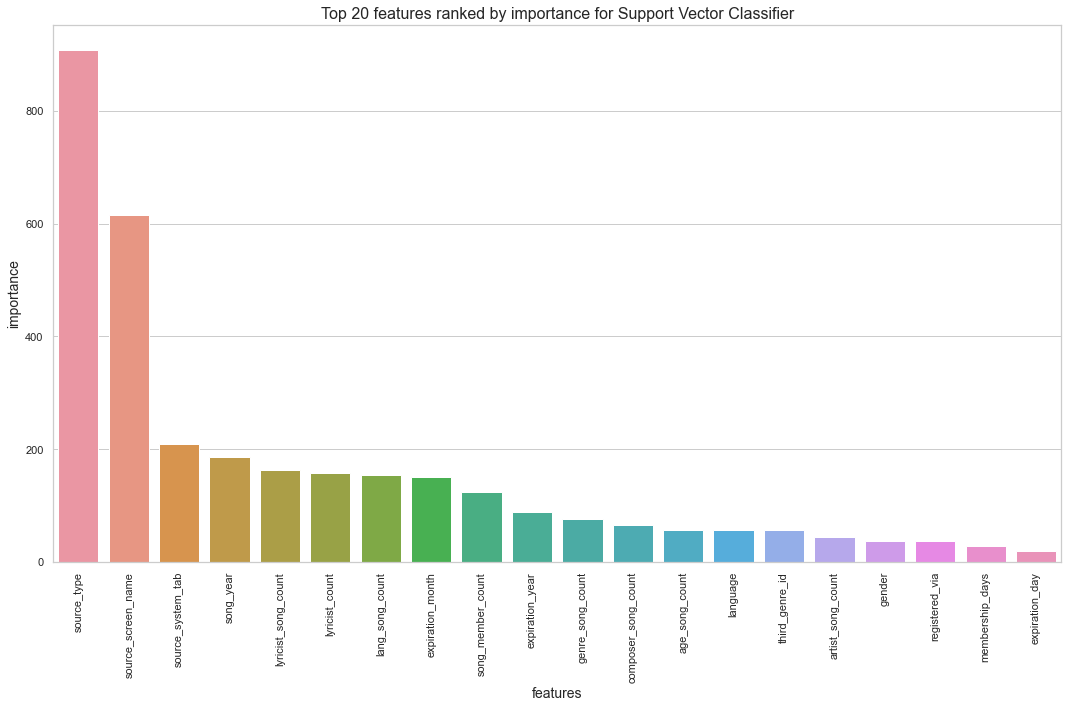

In [22]:
plot_feature_importance(data = svc_fea_imp, model='Support Vector Classifier')

## Decision Tree

### Fitting Decision Tree Classifier

In [23]:
dt_clf = DecisionTreeClassifier(max_depth=15, max_features=None, max_leaf_nodes=90, min_samples_split=10)

In [24]:
dt_clf.fit(X_tr, y_tr)

DecisionTreeClassifier(max_depth=15, max_leaf_nodes=90, min_samples_split=10)

### Generating the classification report

In [25]:
class_report(dt_clf)

Classification Report of  DecisionTreeClassifier  on training dataset

              precision    recall  f1-score   support

           0       0.67      0.59      0.63    586166
           1       0.64      0.71      0.67    594221

    accuracy                           0.65   1180387
   macro avg       0.65      0.65      0.65   1180387
weighted avg       0.65      0.65      0.65   1180387



Classification Report of  DecisionTreeClassifier  on validation dataset

              precision    recall  f1-score   support

           0       0.66      0.59      0.63    146548
           1       0.64      0.70      0.67    148549

    accuracy                           0.65    295097
   macro avg       0.65      0.65      0.65    295097
weighted avg       0.65      0.65      0.65    295097



### ROC-AUC

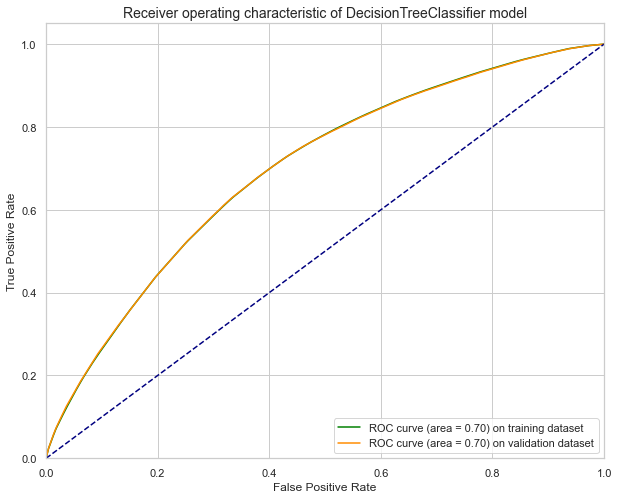

In [26]:
plot_roc(dt_clf)

### Error analysis : Confusion Matrix on validation dataset

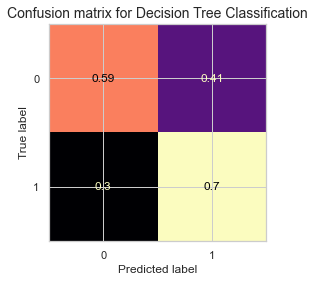

In [27]:
plot_confusion_matrix(dt_clf, X_val, y_val, normalize = 'true', colorbar=False, cmap='magma')
plt.title("Confusion matrix for Decision Tree Classification", fontsize=14)
plt.show()

### Feature importance

In [28]:
# create dataframe for features and it importance

sorted_indices = np.abs(dt_clf.feature_importances_).argsort()[::-1][:20]
imp_features = features[sorted_indices]
dt_fea_imp = pd.DataFrame({
    'features' : imp_features,
    'importance' : np.abs(dt_clf.feature_importances_)[sorted_indices]
})

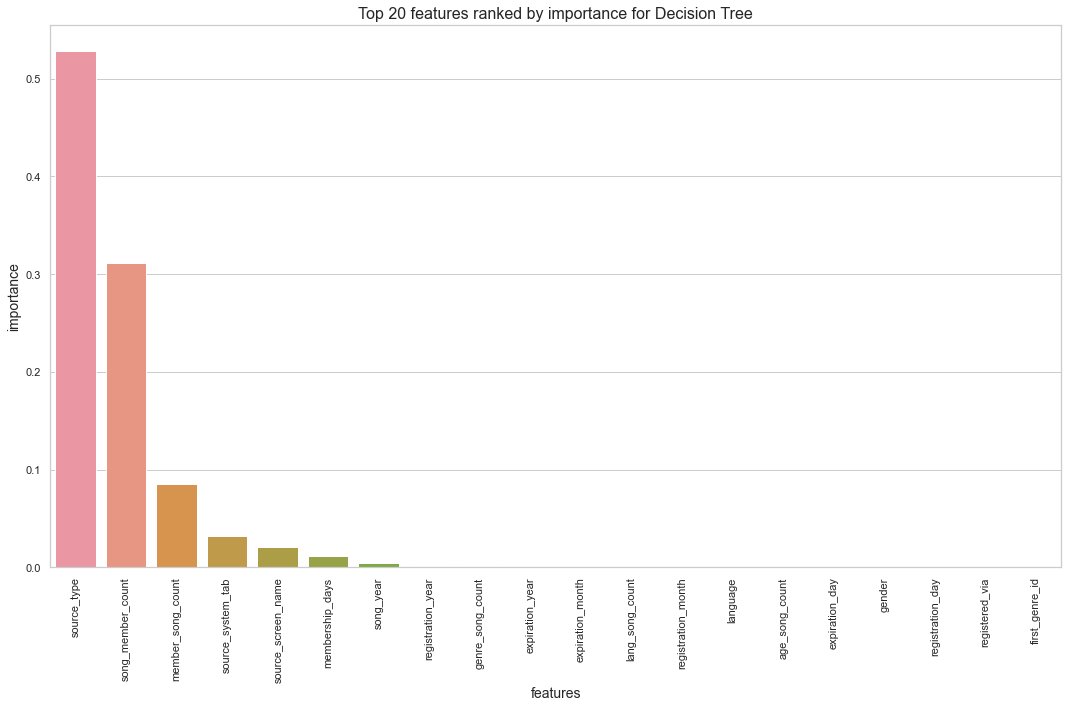

In [29]:
plot_feature_importance(data = dt_fea_imp, model = "Decision Tree")

## Conclusion and Next Step

From the above analysis we can conclude that Decision Tree is performing best in the hold out data. Giving ROC-AUC of 0.7 and accuracy 0.65.

Next we shall implement more complex algorithms for this task.